# Klue augmentation(x)

## 0. 라이브러리

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

## 1. 데이터 불러오기

In [2]:
train_data_path ="~/aiffel/dktc/data2/train0.csv"
train_data = pd.read_csv(train_data_path,index_col=0)
train_data.head(20)

,class,conversation
idx,,
1,기타 괴롭힘 대화,저기요 사장님\n네 무슨일인가요?\n제가 여기서 짜장면을 사갔는데.상태가 안좋네요....
2,협박 대화,어꺠를 쳤으면 사과를 해야지.\n세상이 말세다. 말세야 너가 뭔데 사과를 해라마라야...
3,협박 대화,이새끼야 내돈가지고와\n한번만 봐주세요 .다음주까지가지고올게요\n됏고 이새끼야 야!...
4,일반 대화,정촌은 버스가 늘어야 행\n너무 불편함\n버스 노선 너무 길어 ㅠㅠ\n버스가 넘 없...
5,직장 내 괴롭힘 대화,박과장 일로와바\n네 부르셨습니까\n요즘 이대리 일을 하는거야 마는거야\n그게 무슨...
6,기타 괴롭힘 대화,야 내말 따라해봐. 안녕하세요. 김길동 입니다.\n어. 왜. 그러지마.\n하하 이거...
7,기타 괴롭힘 대화,아가씨 여기 뭐가 맛있어\n 여기 볶음밥이 맛있습니다\n 아가씨도 먹어봤어?\n 네...
8,협박 대화,좋게 좋게 갑시다. 어차피 두개 달린거 하나 없다고 죽는 것도 아니잖아?\n왜 이러...
9,협박 대화,어이 김씨 가져왔지?\n모으고 있는중입니다\n머? 내 말을 입으로 쳐드셨나? 이 쉐...


In [3]:
print('훈련용 문단 개수 :',len(train_data))

훈련용 문단 개수 : 4830


In [4]:
train_data["class"].unique()

array(['기타 괴롭힘 대화', '협박 대화', '일반 대화', '직장 내 괴롭힘 대화', '갈취 대화'],
      dtype=object)

In [5]:
# class 별 데이터 내용 확인

In [6]:
print(train_data['conversation'].values[0]) # 일상대화

저기요 사장님
네 무슨일인가요?
제가 여기서 짜장면을 사갔는데.상태가 안좋네요.환불해주세요
죄송합니다 언제 사가셨는데요?
어제요 빨리 환불해주세요
죄송합니다.어제 사가셨으면 환불은 어려우세요
그럼 이걸 나보고 먹으라고?
아니요.
그럼요 .
잠시만 기다려주세요


In [7]:
print(train_data['conversation'].values[2]) # 기타 괴롭힘 대화

이새끼야 내돈가지고와
한번만 봐주세요 .다음주까지가지고올게요
됏고 이새끼야 야! 다 뒤져
네
어서 못해.
살려주세요
너지금 몇번짼지알아. 됏고 너 간이랑 신장내놔
여기도장찍어!
살려쥐세요 제발
야 여기 칼가져와 장기좀빼내자
여기잇읍니다


In [8]:
print(train_data['conversation'].values[3]) # 갈취 대화

정촌은 버스가 늘어야 행
너무 불편함
버스 노선 너무 길어 ㅠㅠ
버스가 넘 없지?
자가용 없었으면 어쩔 뻔 ㅇ
버스 진짜 없어 정촌에
노선도 3개 뿐인 듯...
주변에 택시도 잘 안 보임
차를 사야겠어 어른
혁신으로 바로 가는 버스 있냐?
콜택시 불러야 댐 ㅜㅜ
바로 가는 건 없는 것 같아
택시 불러도 진짜 안 옴!
윽 그건 좀 불편하겠다 ㅜㅜ
택시는 비싸고 버스는 없고 ㅠㅠ
간혹 아파트에 사는 택시 기사님 빨리 옴... 키키
바로 가는 거 왜 없엉
민원 넣자
카카오 택시 불러야지 ㅠㅠ


In [9]:
print(train_data['conversation'].values[6]) # 협박 대화

아가씨 여기 뭐가 맛있어
 여기 볶음밥이 맛있습니다
 아가씨도 먹어봤어?
 네 제가 먹어봤는데 맛있어요
 아가씨도 맛있어보이는데
 네?
 네?가 아니라 맛있어보인다고
 하.
 기분나뻐? 기분나쁘면 이런데서 알바하지말아야지
 신고할거에요


In [10]:
print(train_data['conversation'].values[16]) # 직장 내 괴롭힘 대화

와 00이봐. 엄청 먹는다.
그러게. 왜저렇게 많이 먹어.
저렇게 먹으니깐 관리가 안돼지.
저 오늘 처음 먹는 식사예요.
그래도 그렇게 먹으면 보기 않좋지
그래 적당히 먹어야지. 언제까지 살도 안빼고 그럴래.
곧 취업하고 결혼해야하는데 관리안한 여자를 누가 데려가니.
저 나름대로 관리중인데.
00아 너 걱정되서 하는 말이야. 살빼야지 언제까지 먹고 관리 안할꺼야. 그만먹어
네.


## 2. 데이터 준비 (Data preparation)
### 2.1-1 전처리 함수 정의

In [11]:
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.replace("\n", " ")
    sentence = sentence.strip()
    return sentence


### 2.1-2 전처리 함수 적용

In [12]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation']):
    sentences.append(preprocess_sentence(val))


100%|██████████| 4830/4830 [00:01<00:00, 3282.19it/s]


### 2.2 최대 길이 지정

In [28]:
MAX_LEN = 250

### 2.3 class(label) 인코딩

In [29]:
from sklearn.preprocessing import LabelEncoder

CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화','일반 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
labels = train_data['class']

len(labels)


/opt/conda/lib/python3.9/site-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [30]:
class_mapping = {class_name: encoder.transform([class_name])[0] for class_name in CLASS_NAMES}
print("Class mapping:", class_mapping)


Class mapping: {'협박 대화': 4, '갈취 대화': 0, '직장 내 괴롭힘 대화': 3, '기타 괴롭힘 대화': 1, '일반 대화': 2}


In [31]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, 
                                    max_length=max_seq_len, 
                                    pad_to_max_length=True,
                                   )
        
        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
        # token_type_id은 세그먼트 인코딩
        token_type_id = [0] * max_seq_len
        
        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)
    
    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    
    data_labels = np.asarray(data_labels, dtype=np.int32)
    
    return (input_ids, attention_masks, token_type_ids), data_labels

### 2.4 train-val

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sentences, labels, test_size=0.2, random_state=42)


## 3. 모델
### 3.1-1 토크나이저 정의

In [33]:
# klue model
model_name = "klue/bert-base"

In [34]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained(model_name)

### 3.1-2 토크나이저 적용

In [35]:
# 데이터셋을 BERT 입력 형식으로 변환
X_train, y_train = convert_examples_to_features(
    X_train, y_train, 
    max_seq_len=MAX_LEN, tokenizer=tokenizer
)
X_valid, y_valid = convert_examples_to_features(
    X_valid, y_valid, 
    max_seq_len=MAX_LEN, tokenizer=tokenizer
)

100%|██████████| 966/966 [00:00<00:00, 1058.39it/s]


In [36]:
class TFBertForMultiClassClassification(tf.keras.Model):
    def __init__(self, model_name, num_classes, dropout_rate=0.1):
        super(TFBertForMultiClassClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.dropout = Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_classes,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                kernel_regularizer=l2(0.01),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        cls_token = outputs[1]
        dropped = self.dropout(cls_token)
        prediction = self.classifier(dropped)
        return prediction

### 3.2 모델 준비

In [37]:
model = TFBertForMultiClassClassification(model_name, num_classes=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

### 3.3 파라미터

In [38]:
BATCH_SIZE = 16
lr = 5e-5
EPOCH = 10

### 3.4 TF 데이터셋 생성

In [39]:
# # TensorFlow 데이터셋 생성
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(train_encodings),
#     train_labels
# )).shuffle(100).batch(BATCH_SIZE)

# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(val_encodings),
#     val_labels
# )).batch(BATCH_SIZE)


### 3.5 모델 컴파일

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 3.6 모델 훈련

### 3.6-1 콜백 설정

In [41]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # 검증 손실을 모니터링
    patience=3,            # 3 에포크 동안 개선되지 않으면 중지
    restore_best_weights=True  # 최상의 가중치를 복원
)

checkpoint = ModelCheckpoint(
    filepath='best_model_weights.h5',  # 모델 가중치를 저장할 파일 경로
    monitor='val_loss',        # 검증 손실을 모니터링
    save_best_only=True,       # 최상의 모델만 저장
    save_weights_only=True,   # 저장 (가중치)
    mode='min',                # 'val_loss'가 최소일 때 저장
    verbose=1                  # 저장 시 로그 출력
)


### 3.6-2 모델 훈련

In [42]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
121/121 [==============================] - 225s 2s/step - loss: 0.5225 - accuracy: 0.8437 - val_loss: 0.3707 - val_accuracy: 0.9089

Epoch 00001: val_loss improved from inf to 0.37073, saving model to best_model_weights.h5
Epoch 2/10
121/121 [==============================] - 211s 2s/step - loss: 0.2215 - accuracy: 0.9586 - val_loss: 0.3619 - val_accuracy: 0.9213

Epoch 00002: val_loss improved from 0.37073 to 0.36188, saving model to best_model_weights.h5
Epoch 3/10
121/121 [==============================] - 211s 2s/step - loss: 0.1381 - accuracy: 0.9863 - val_loss: 0.4524 - val_accuracy: 0.9058

Epoch 00003: val_loss did not improve from 0.36188
Epoch 4/10
121/121 [==============================] - 210s 2s/step - loss: 0.1224 - accuracy: 0.9876 - val_loss: 0.5203 - val_accuracy: 0.8986

Epoch 00004: val_loss did not improve from 0.36188
Epoch 5/10
121/121 [==============================] - 210s 2s/step - loss: 0.1307 - accuracy: 0.9834 - val_loss: 0.5110 - val_accuracy: 0.

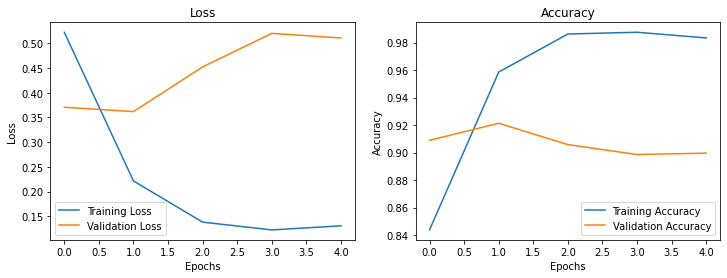

In [59]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3.7 모델 평가

In [43]:
# 모델 평가
evaluation = model.evaluate(X_valid, y_valid)
print("평가 결과:", evaluation)

31/31 [==============================] - 17s 536ms/step - loss: 0.3619 - accuracy: 0.9213
평가 결과: [0.36187562346458435, 0.9213250279426575]


### 3.8 결과 분석

In [44]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

def score(model, val):
    X, y = val
    # 실제 예측값 생성
    real_predictions = model.predict(X)

    # 예측값을 레이블로 변환
    real_predicted_labels = np.argmax(real_predictions, axis=1)

    # 정확도 계산
    real_accuracy = accuracy_score(y, real_predicted_labels)
    print(f"Real Accuracy: {real_accuracy:.4f}")

    # 분류 보고서 생성
    real_report = classification_report(y, real_predicted_labels, target_names=[f"Class {i}" for i in range(5)])
    print(real_report)

    # F1 스코어 계산
    real_f1 = f1_score(y, real_predicted_labels, average='weighted')
    print(f"\nWeighted F1 Score (based on real predictions): {real_f1:.4f}")

In [45]:
score(model, (X_valid, y_valid))

Real Accuracy: 0.9213
              precision    recall  f1-score   support

     Class 0       0.89      0.90      0.90       211
     Class 1       0.91      0.86      0.88       208
     Class 2       0.99      1.00      1.00       169
     Class 3       0.94      0.96      0.95       195
     Class 4       0.88      0.91      0.89       183

    accuracy                           0.92       966
   macro avg       0.92      0.92      0.92       966
weighted avg       0.92      0.92      0.92       966


Weighted F1 Score (based on real predictions): 0.9211


AUC Score: 0.9880


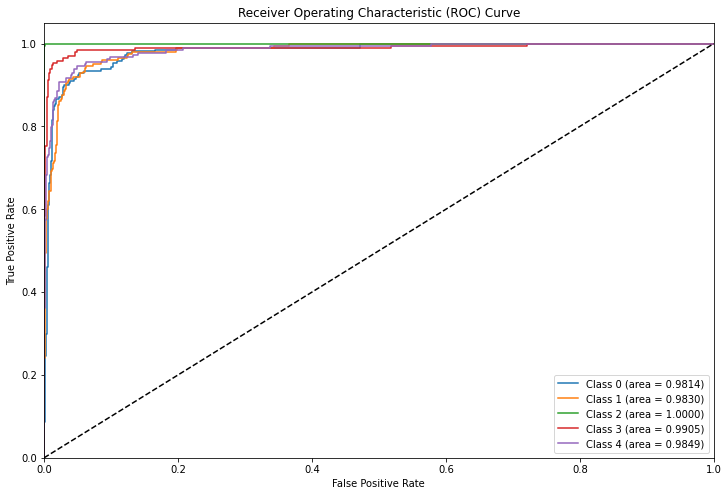

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

def plot_auc_roc(model, val, n_classes):
    X, y = val
    # 실제 예측값 생성
    real_predictions = model.predict(X)
    
    # 레이블을 이진화
    y_bin = label_binarize(y, classes=[i for i in range(n_classes)])

    # AUC 점수 계산
    auc = roc_auc_score(y_bin, real_predictions, multi_class="ovr")
    print(f"AUC Score: {auc:.4f}")

    # 각 클래스별 AUC-ROC 커브 그리기
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], real_predictions[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], real_predictions[:, i])

    # ROC 커브 그리기
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

n_classes = 5
plot_auc_roc(model, (X_valid, y_valid), n_classes)

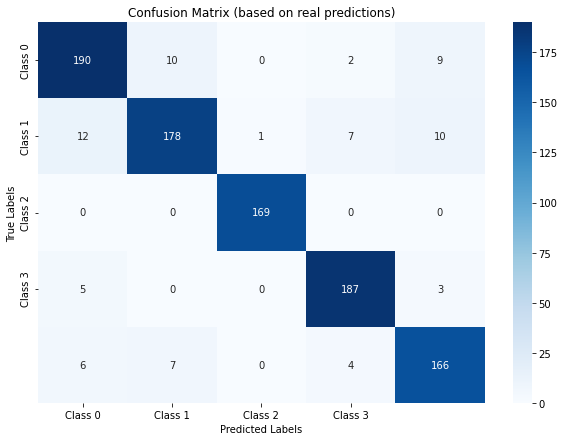

In [53]:
# 혼동 행렬 생성 및 표시
import seaborn as sns
real_predictions = model.predict(X_valid)
real_predicted_labels = np.argmax(real_predictions, axis=1)
real_conf_matrix = confusion_matrix(y_valid, real_predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(real_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=[f"Class {i}" for i in range(4)], yticklabels=[f"Class {i}" for i in range(4)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (based on real predictions)')
plt.show()

## 4. 모델 적용

In [46]:
import json

test_data_path = "/aiffel/aiffel/dktc/data/test.json"

test = pd.read_json(test_data_path).transpose()

# with open(test_data_path, "r", encoding="utf-8") as json_file:
#     test = json.load(json_file)

In [47]:
print(test.head())

                                                    text
t_000  아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001  우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? ...
t_002  너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003  이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004  아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [48]:
import numpy as np

test_predict = []

for idx, value in test.iterrows():

    test_sentence = value["text"]
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="tf")

    test_predictions = model.predict(
        (test_encodings["input_ids"],
            test_encodings["attention_mask"],
            test_encodings["token_type_ids"])
    )
    test_class_probabilities = tf.nn.softmax(test_predictions, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predict.append(test_predicted_class[0])


In [ ]:
print(len(test_predict))

In [ ]:
print(test_predict[:5])

In [56]:
# {'협박 대화': 4, '갈취 대화': 0, '직장 내 괴롭힘 대화': 3, '기타 괴롭힘 대화': 1, '일반 대화': 2}

def labelnum_to_text(x):
    if x == 0:
        return '01'
    if x == 1:
        return '03'
    if x == 2:
        return '04'
    if x == 3:
        return '02'
    if x == 4:
        return '00'
    
submission = pd.DataFrame({"file_name":test.index, 'class':test_predict})

submission['class'] = submission['class'].apply(labelnum_to_text)
submission.head()

,file_name,class
0,t_000,01
1,t_001,02
2,t_002,02
3,t_003,03
4,t_004,03


In [57]:
submission.to_csv('~/aiffel/dktc/data2/submission_klue.csv', index=False)

In [58]:
pd.read_csv("~/aiffel/dktc/data2/submission_klue.csv").head()

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
